# Lab3 ResNet18
weighted loss + normalize

In [1]:
import os
import torch
print(torch.__version__)
print(torch.cuda.is_available())
device=torch.device('cuda',0)
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
import torch.nn as nn
import torch.optim as optim
import copy
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1.4.0
True


## DataSet & DataLoader
data augmentation:  
1. RandomHorizontalFlip
2. RandomVerticalFilp
3. Normalize each channel(R,G,B)

In [2]:
class RetinopathyDataSet(Dataset):
    def __init__(self, img_path, mode):
        """
        Args:
            img_path: Root path of the dataset.
            mode: training/testing
            
            self.img_names (string list): String list that store all image names.
            self.labels (int or float list): Numerical list that store all ground truth label values.
        """
        self.img_path = img_path
        self.mode = mode
        
        self.img_names=np.squeeze(pd.read_csv('train_img.csv' if mode=='train' else 'test_img.csv').values)
        self.labels=np.squeeze(pd.read_csv('train_label.csv' if mode=='train' else 'test_label.csv').values)
        assert len(self.img_names)==len(self.labels),'length not the same'
        self.data_len=len(self.img_names)
        
        self.transformations=transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.ToTensor(),
                                                transforms.Normalize([0.5769, 0.3852, 0.2649],[0.1061, 0.0809, 0.0555])])
        print(f'>> Found {self.data_len} images...')
        
    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        single_img_name=os.path.join(self.img_path,self.img_names[index]+'.jpeg')
        single_img=Image.open(single_img_name)  # read an PIL image
        img=self.transformations(single_img)
        label=self.labels[index]
        
        return img, label

## Model
1. ResNet18 (with/wo pretrained weights)
2. ResNet50 (with/wo pretrained weights)

reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks  

In [3]:
class ResNet18(nn.Module):
    def __init__(self,num_class,pretrained=False):
        """
        Args:
            num_class: #target class
            pretrained: 
                True: the model will have pretrained weights, and only the last layer's 'requires_grad' is True(trainable)
                False: random initialize weights, and all layer's 'require_grad' is True
        """
        super(ResNet18,self).__init__()
        self.model=models.resnet18(pretrained=pretrained)
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad=False
        num_neurons=self.model.fc.in_features
        self.model.fc=nn.Linear(num_neurons,num_class)
        
    def forward(self,X):
        out=self.model(X)
        return out
    
class ResNet50(nn.Module):
    def __init__(self,num_class,pretrained=False):
        """
        Args:
            num_class: #target class
            pretrained: 
                True: the model will have pretrained weights, and only the last layer's 'requires_grad' is True(trainable)
                False: random initialize weights, and all layer's 'require_grad' is True
        """
        super(ResNet50,self).__init__()
        self.model=models.resnet50(pretrained=pretrained)
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad=False
        num_neurons=self.model.fc.in_features
        self.model.fc=nn.Linear(num_neurons,num_class)
        
    def forward(self,X):
        out=self.model(X)
        return out

## Train & Evaluate

In [4]:
def train(model,loader_train,loader_test,Loss,optimizer,epochs,device,num_class,name):
    """
    Args:
        model: resnet model
        loader_train: training dataloader
        loader_test: testing dataloader
        Loss: loss function
        optimizer: optimizer
        epochs: number of training epoch
        device: gpu/cpu
        num_class: #target class
        name: model name when saving model
    Returns:
        dataframe: with column 'epoch','acc_train','acc_test'
    """
    df=pd.DataFrame()
    df['epoch']=range(1,epochs+1)
    best_model_wts=None
    best_evaluated_acc=0
    
    model.to(device)
    acc_train=list()
    acc_test=list()
    for epoch in range(1,epochs+1):
        """
        train
        """
        with torch.set_grad_enabled(True):
            model.train()
            total_loss=0
            correct=0
            for images,targets in loader_train:
                images,targets=images.to(device),targets.to(device,dtype=torch.long)
                predict=model(images)
                loss=Loss(predict,targets)
                total_loss+=loss.item()
                correct+=predict.max(dim=1)[1].eq(targets).sum().item()
                """
                update
                """
                optimizer.zero_grad()
                loss.backward()  # bp
                optimizer.step()
            total_loss/=len(loader_train.dataset)
            acc=100.*correct/len(loader_train.dataset)
            acc_train.append(acc)
            print(f'epoch{epoch:>2d} loss:{total_loss:.4f} acc:{acc:.2f}%')
        """
        evaluate
        """
        _,acc=evaluate(model,loader_test,device,num_class)
        acc_test.append(acc)
        # update best_model_wts
        if acc>best_evaluated_acc:
            best_evaluated_acc=acc
            best_model_wts=copy.deepcopy(model.state_dict())
    
    df['acc_train']=acc_train
    df['acc_test']=acc_test
    
    # save model
    torch.save(best_model_wts,os.path.join('models',name+'.pt'))
    
    return df

In [5]:
def evaluate(model,loader_test,device,num_class):
    """
    Args:
        model: resnet model
        loader_test: testing dataloader
        device: gpu/cpu
        num_class: #target class
    Returns:
        confusion_matrix: (num_class,num_class) ndarray
        acc: accuracy rate
    """
    confusion_matrix=np.zeros((num_class,num_class))
    
    with torch.set_grad_enabled(False):
        model.eval()
        correct=0
        for images,targets in loader_test:  
            images,targets=images.to(device),targets.to(device,dtype=torch.long)
            predict=model(images)
            predict_class=predict.max(dim=1)[1]
            correct+=predict_class.eq(targets).sum().item()
            for i in range(len(targets)):
                confusion_matrix[int(targets[i])][int(predict_class[i])]+=1
        acc=100.*correct/len(loader_test.dataset)
        
    # normalize confusion_matrix
    confusion_matrix=confusion_matrix/confusion_matrix.sum(axis=1).reshape(num_class,1)
    
    return confusion_matrix,acc

## Plot

In [6]:
def plot(dataframe1,title):
    """
    Arguments:
        dataframe1: dataframe with 'epoch','acc_train','acc_test' columns of with pretrained weights model 
        title: figure's title
    Returns:
        figure: an figure
    """
    fig=plt.figure(figsize=(10,6))
    for name in dataframe1.columns[1:]:
        plt.plot(range(1,1+len(dataframe1)),name,data=dataframe1,label=name[4:]+'(with pretraining)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy(%)')
    plt.title(title)
    plt.legend()
    return fig

def plot_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
    ax.xaxis.set_label_position('top')
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(i, j, '{:.2f}'.format(confusion_matrix[j, i]), va='center', ha='center')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    return fig

## Hyperparameters
__num_class__: 5  
__batch_size:__  
1. Resnet18: 64
2. Resnet50: 16

__learning rate:__ 5e-4/1e-3  
__Epochs:__  
1. model wo pretrained weights: 20
2. model with pretrained weights: 4(feature extraction) + 16(finetuning)

__Optimizer:__ SGD,momentum=0.9,weight_decay=5e-4  
__loss function:__ cross entropy  

In [8]:
num_class=5
batch_size=64
lr=1e-3
epochs=30
epochs_feature_extraction=5
epochs_fine_tuning=45
momentum=0.9
weight_decay_feature_extraction=5e-4
weight_decay_finetuning=5e-4
Loss=nn.CrossEntropyLoss(weight=torch.Tensor([1.0,10.565217391304348,4.906175771971497,29.591690544412607,35.55077452667814]).to(device))

# Run ResNet18

In [8]:
dataset_train=RetinopathyDataSet(img_path='data',mode='train')
loader_train=DataLoader(dataset=dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

dataset_test=RetinopathyDataSet(img_path='data',mode='test')
loader_test=DataLoader(dataset=dataset_test,batch_size=batch_size,shuffle=False,num_workers=4)

>> Found 28099 images...
>> Found 7025 images...


epoch 1 loss:0.0233 acc:29.81%
epoch 2 loss:0.0213 acc:38.55%
epoch 3 loss:0.0207 acc:40.36%
epoch 4 loss:0.0204 acc:40.24%
epoch 5 loss:0.0202 acc:41.08%
epoch 1 loss:0.0196 acc:42.89%
epoch 2 loss:0.0174 acc:48.54%
epoch 3 loss:0.0161 acc:52.88%
epoch 4 loss:0.0157 acc:53.73%
epoch 5 loss:0.0147 acc:55.47%
epoch 6 loss:0.0138 acc:57.14%
epoch 7 loss:0.0136 acc:58.89%
epoch 8 loss:0.0132 acc:59.32%
epoch 9 loss:0.0123 acc:61.51%
epoch10 loss:0.0118 acc:61.98%
epoch11 loss:0.0117 acc:61.65%
epoch12 loss:0.0108 acc:64.03%
epoch13 loss:0.0104 acc:65.11%
epoch14 loss:0.0104 acc:66.05%
epoch15 loss:0.0098 acc:66.92%
epoch16 loss:0.0093 acc:67.70%
epoch17 loss:0.0084 acc:69.42%
epoch18 loss:0.0080 acc:70.94%
epoch19 loss:0.0075 acc:72.33%
epoch20 loss:0.0071 acc:73.79%
epoch21 loss:0.0070 acc:74.70%
epoch22 loss:0.0064 acc:76.21%
epoch23 loss:0.0065 acc:76.92%
epoch24 loss:0.0063 acc:76.66%
epoch25 loss:0.0053 acc:79.87%
epoch26 loss:0.0067 acc:76.20%
epoch27 loss:0.0048 acc:81.62%
epoch28 

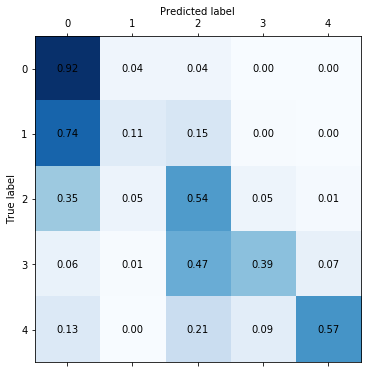

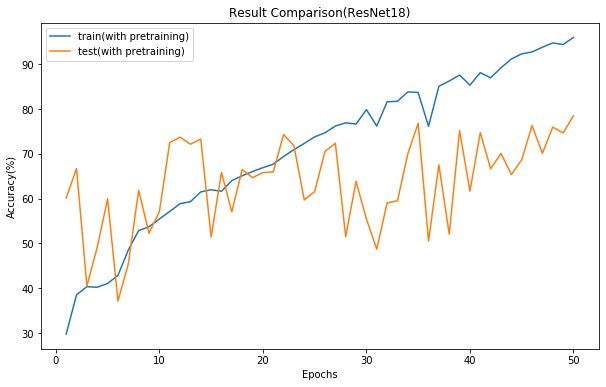

In [9]:
"""
resnet18 without pretrained weights
"""
'''
model_wo=ResNet18(num_class=num_class,pretrained=False)
optimizer=optim.SGD(model_wo.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
df_wo_pretrained=train(model_wo,loader_train,loader_test,Loss,optimizer,epochs,device,num_class,'resnet18_wo_pretraining')
# test and save confusion matrix figure
confusion_matrix,_=evaluate(model_wo,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet18 (wo pretrained weights).png')
'''
"""
resnet18 with pretrained weights
    feature extraction for few epochs, then finefuning for some epochs
"""
model_with=ResNet18(num_class=num_class,pretrained=True)
# feature extraction
params_to_update=[]
for name,param in model_with.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
optimizer=optim.SGD(params_to_update,lr=lr,momentum=momentum,weight_decay=weight_decay_feature_extraction)
df_firststep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_feature_extraction,device,num_class,'resnet18_with_pretraining')
# finetuning
for param in model_with.parameters():
    param.requires_grad=True
optimizer=optim.SGD(model_with.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay_finetuning)
df_secondstep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_fine_tuning,device,num_class,'resnet18_with_pretraining')
df_with_pretrained=pd.concat([df_firststep,df_secondstep],axis=0,ignore_index=True)

# test and get a confusion matrix
confusion_matrix,_=evaluate(model_with,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet18 (with pretrained weights).png')

"""
plot accuracy figure
"""
figure=plot(df_with_pretrained,'Result Comparison(ResNet18)')
figure.savefig('Result Comparison(ResNet18).png')

In [10]:
print(df_with_pretrained)

    epoch  acc_train   acc_test
0       1  29.808890  60.156584
1       2  38.545856  66.718861
2       3  40.360867  40.512456
3       4  40.239866  49.181495
4       5  41.079754  59.971530
5       1  42.887647  37.153025
6       2  48.539094  45.423488
7       3  52.877327  61.879004
8       4  53.727891  52.298932
9       5  55.471725  57.096085
10      6  57.140824  72.512456
11      7  58.888217  73.722420
12      8  59.322396  72.156584
13      9  61.511086  73.281139
14     10  61.984412  51.444840
15     11  61.646322  65.864769
16     12  64.030748  57.081851
17     13  65.112637  66.519573
18     14  66.048614  64.683274
19     15  66.916972  65.822064
20     16  67.696359  65.964413
21     17  69.415282  74.320285
22     18  70.942026  71.772242
23     19  72.333535  59.715302
24     20  73.789103  61.565836
25     21  74.700167  70.548043
26     22  76.209118  72.370107
27     23  76.917328  51.516014
28     24  76.657532  63.886121
29     25  79.867611  55.459075
30     2

## Run ResNet50

In [9]:
batch_size=8

In [10]:
dataset_train=RetinopathyDataSet(img_path='data',mode='train')
loader_train=DataLoader(dataset=dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

dataset_test=RetinopathyDataSet(img_path='data',mode='test')
loader_test=DataLoader(dataset=dataset_test,batch_size=batch_size,shuffle=False,num_workers=4)

>> Found 28099 images...
>> Found 7025 images...


epoch 1 loss:0.2141 acc:42.83%
epoch 2 loss:0.2035 acc:46.00%
epoch 3 loss:0.2073 acc:45.56%
epoch 4 loss:0.1996 acc:47.38%
epoch 5 loss:0.1997 acc:46.77%
epoch 1 loss:0.1624 acc:59.77%
epoch 2 loss:0.1424 acc:67.56%
epoch 3 loss:0.1351 acc:69.55%
epoch 4 loss:0.1307 acc:70.40%
epoch 5 loss:0.1262 acc:71.27%
epoch 6 loss:0.1245 acc:71.58%
epoch 7 loss:0.1229 acc:72.30%
epoch 8 loss:0.1214 acc:72.48%
epoch 9 loss:0.1198 acc:73.32%
epoch10 loss:0.1191 acc:73.09%
epoch11 loss:0.1164 acc:73.81%
epoch12 loss:0.1161 acc:73.73%
epoch13 loss:0.1141 acc:73.81%
epoch14 loss:0.1139 acc:73.38%
epoch15 loss:0.1129 acc:73.86%
epoch16 loss:0.1111 acc:74.43%
epoch17 loss:0.1099 acc:73.78%
epoch18 loss:0.1089 acc:74.53%
epoch19 loss:0.1081 acc:73.37%
epoch20 loss:0.1069 acc:74.70%
epoch21 loss:0.1063 acc:74.18%
epoch22 loss:0.1062 acc:74.40%
epoch23 loss:0.1044 acc:74.83%
epoch24 loss:0.1045 acc:74.69%
epoch25 loss:0.1041 acc:73.92%
epoch26 loss:0.1020 acc:74.86%
epoch27 loss:0.1027 acc:74.49%
epoch28 

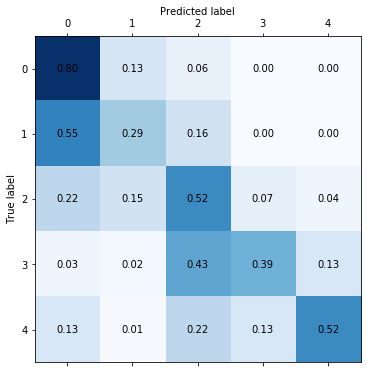

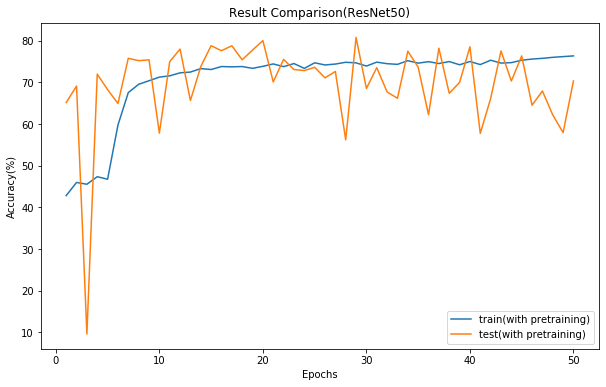

In [11]:
"""
resnet50 without pretrained weights
"""
'''
model_wo=ResNet50(num_class=num_class,pretrained=False)
optimizer=optim.SGD(model_wo.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
df_wo_pretrained=train(model_wo,loader_train,loader_test,Loss,optimizer,epochs,device,num_class,'resnet50_wo_pretraining')
# test and save confusion matrix figure
confusion_matrix,_=evaluate(model_wo,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet50 (wo pretrained weights).png')
'''
"""
resnet50 with pretrained weights
    first feature extraction for few epochs, then finefuning for some epochs
"""
model_with=ResNet50(num_class=num_class,pretrained=True)
# feature extraction
params_to_update=[]
for name,param in model_with.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
optimizer=optim.SGD(params_to_update,lr=lr,momentum=momentum,weight_decay=weight_decay_feature_extraction)
df_firststep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_feature_extraction,device,num_class,'resnet50_with_pretraining')
# finetuning
for param in model_with.parameters():
    param.requires_grad=True
optimizer=optim.SGD(model_with.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay_finetuning)
df_secondstep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_fine_tuning,device,num_class,'resnet50_with_pretraining')
df_with_pretrained=pd.concat([df_firststep,df_secondstep],axis=0,ignore_index=True)

# test and get a confusion matrix
confusion_matrix,_=evaluate(model_with,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet50 (with pretrained weights).png')

"""
plot accuracy figure
"""
figure=plot(df_with_pretrained,'Result Comparison(ResNet50)')
figure.savefig('Result Comparison(ResNet50).png')

In [12]:
print(df_with_pretrained)

    epoch  acc_train   acc_test
0       1  42.834265  65.167260
1       2  45.998078  69.124555
2       3  45.563899   9.637011
3       4  47.375351  71.971530
4       5  46.766789  68.270463
5       1  59.770810  64.939502
6       2  67.557564  75.786477
7       3  69.550518  75.217082
8       4  70.397523  75.416370
9       5  71.265881  57.836299
10      6  71.579060  74.989324
11      7  72.297947  77.992883
12      8  72.483007  65.651246
13      9  73.315776  73.793594
14     10  73.091569  78.804270
15     11  73.806897  77.608541
16     12  73.728602  78.790036
17     13  73.806897  75.430605
18     14  73.376277  77.765125
19     15  73.860280  80.028470
20     16  74.433254  70.106762
21     17  73.781985  75.516014
22     18  74.525784  73.096085
23     19  73.365600  72.839858
24     20  74.703726  73.622776
25     21  74.184135  71.088968
26     22  74.401224  72.626335
27     23  74.828286  56.227758
28     24  74.689491  80.782918
29     25  73.920780  68.540925
30     2